In [ ]:
import numpy as np

import pandas as pd

import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import gc
import time
import seaborn as sns

SEED=42

In [ ]:
from google.colab import files
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd


# Step 2: Load the files
X = np.load('/content/X (3).npy')
y = np.load('/content/Y (1).npy')
balanced_df = pd.read_csv("/content/balanced_df (1).csv")

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')


Shape of X: (20000, 128, 128, 3)
Shape of y: (20000,)


In [ ]:
#Label Encoding
classes = balanced_df['landmark_id'].unique()
y=np.array(y)

LE = LabelEncoder()
LE.fit(classes)
y_encoded = LE.transform(y)

In [ ]:
balanced_df

,id,landmark_id,img_path
0,5be630f93b7a6154,27,../input/landmark-recognition-2021/train/5/b/e...
1,8fb6a0f14c54a819,27,../input/landmark-recognition-2021/train/8/f/b...
2,f8db65723dd99b0f,27,../input/landmark-recognition-2021/train/f/8/d...
3,2873e03760ca2fca,27,../input/landmark-recognition-2021/train/2/8/7...
4,a0818e1222c8f95b,27,../input/landmark-recognition-2021/train/a/0/8...
...,...,...,...
19995,b7f5f904a403e273,202886,../input/landmark-recognition-2021/train/b/7/f...
19996,ae5e21b02217fec1,202886,../input/landmark-recognition-2021/train/a/e/5...
19997,117dfe4b61ecf014,202886,../input/landmark-recognition-2021/train/1/1/7...
19998,a5d929026425a173,202886,../input/landmark-recognition-2021/train/a/5/d...


In [ ]:
# Splitting data into training, validation, and testing sets

# First, split the data into training and validation sets (90% training, 10% validation)
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y_encoded, test_size=0.10, random_state=42, shuffle=True)

# Next, split a portion of the training data into a test set (5% of the full dataset)
X_train, X_test, y_train, y_test = train_test_split(X_train_full, y_train_full, test_size=0.05, random_state=42, shuffle=True)

# Check data distribution across sets
print(f"Total Images: {len(X)}, Total Labels: {len(y_encoded)}")
print(f"Training Set - Images: {len(X_train)}, Labels: {len(y_train)}")
print(f"Validation Set - Images: {len(X_val)}, Labels: {len(y_val)}")
print(f"Test Set - Images: {len(X_test)}, Labels: {len(y_test)}")

Total Images: 20000, Total Labels: 20000
Training Set - Images: 17100, Labels: 17100
Validation Set - Images: 2000, Labels: 2000
Test Set - Images: 900, Labels: 900


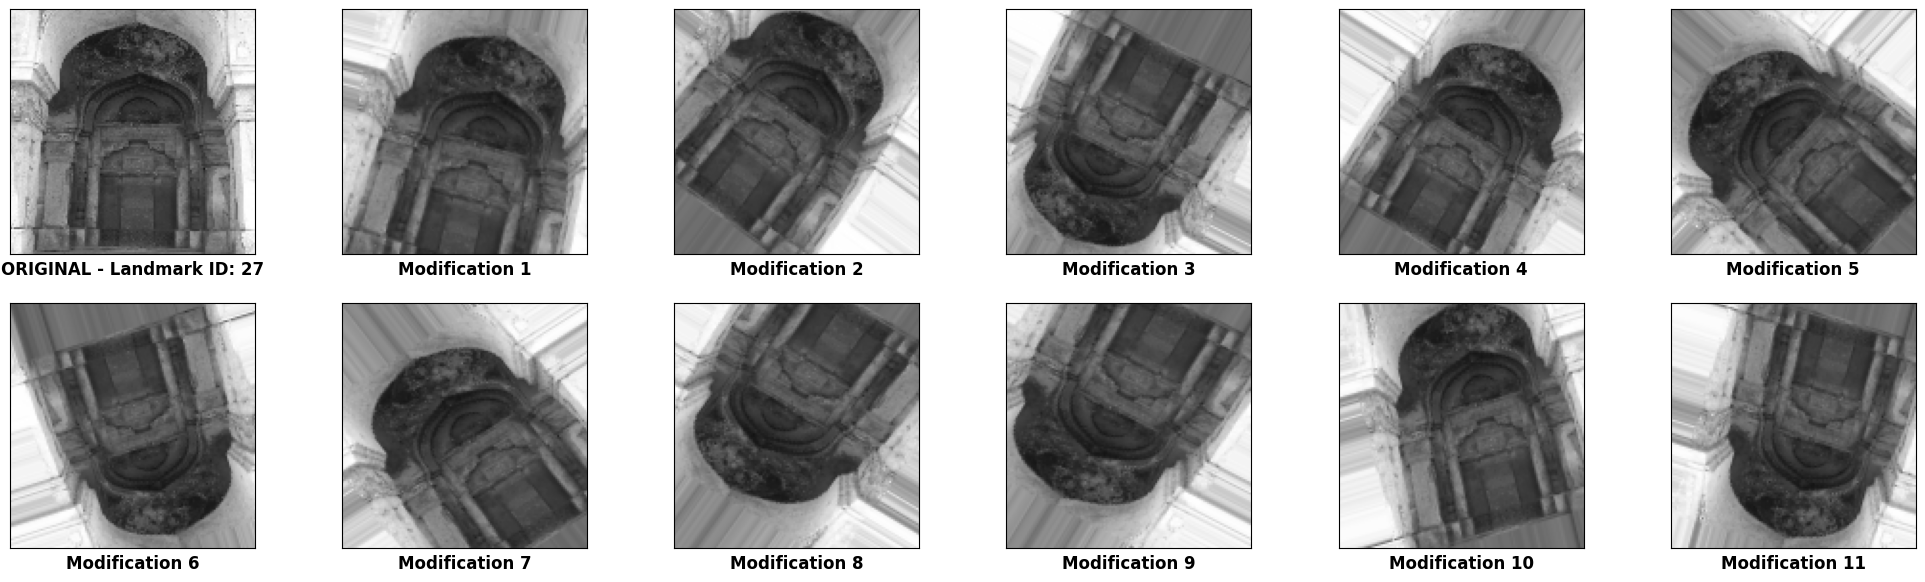

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Define the data augmentation pipeline with ImageDataGenerator
data_gen = ImageDataGenerator(
    rotation_range=54,        # Rotate by ±15% of 360 degrees (~54 degrees)
    width_shift_range=0.1,    # Translate horizontally by 10%
    height_shift_range=0.1,   # Translate vertically by 10%
    zoom_range=[0.9, 1.1],    # Zoom in/out by 10%
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=True,       # Randomly flip images vertically
    fill_mode='nearest'       # Fill in missing pixels after transformations
)

# Load an example image (replace X[image_index] with your actual image)
image_index = 1  # Index of the image to display
original_image = X[image_index]  # X should be your image dataset (e.g., NumPy array)
original_image = np.expand_dims(original_image, axis=0)  # Add batch dimension

# Ensure image pixel values are in range [0, 255] for visualization
original_image = (original_image * 255).astype("uint8") if original_image.max() <= 1 else original_image

# Plot original image
plt.figure(figsize=(25, 7))
plt.subplot(2, 6, 1)
plt.xticks([])
plt.yticks([])
plt.xlabel(f'ORIGINAL - Landmark ID: {y[image_index]}', fontweight="bold", fontsize=12)
plt.imshow(original_image[0])  # Remove batch dimension for display

# Plot augmented images
augmented_images = data_gen.flow(original_image, batch_size=1)
for i in range(11):
    augmented_image = next(augmented_images)[0].astype("uint8")  # Generate augmented image
    plt.subplot(2, 6, i + 2)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'Modification {i + 1}', fontweight="bold", fontsize=12)
    plt.imshow(augmented_image)

plt.show()


In [ ]:

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),               # Randomly flip images both horizontally and vertically
    RandomRotation(0.2),                                 # Randomly rotate images by up to 20%
    RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),  # Randomly zoom in/out by up to 10%
    RandomContrast(0.3),                                 # Randomly adjust contrast by up to ±0.3
    RandomTranslation(height_factor=0.1, width_factor=0.1)  # Randomly shift images up to 10% in any direction
])

In [ ]:
# CNN Hyperparameters
IMG_SIZE = 128
kernelSize = (3,3)         #Convolution template size
paddingType = 'same'
activationF = 'relu'      # Activation Function
poolSize = (2,2)          # Maximum pooling template size
stridesSize = (2,2)       # Template offset during maximum pooling
dropoutRate = 0.5         # Percentage of neurons that are deactivated with the Dropout layer
batchSize = 256           # Amount of data with which it is trained in each epoch
epochsSize= 1000          # Number of epochs to train
lr = 0.01                # Learning Rate
weightDecay = regularizers.L2(0.01) # Regularization of weights

In [ ]:
model = keras.Sequential([
    data_augmentation,  # Data augmentation layer
    # Convolutional block 1
    layers.Conv2D(filters=32, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF, input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),
    # Convolutional block 2
    layers.Conv2D(filters=64, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),
    # Convolutional block 3
    layers.Conv2D(filters=128, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),
    # Convolutional block 4
    layers.Conv2D(filters=256, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),
    # Convolutional block 5
    layers.Conv2D(filters=512, kernel_size=kernelSize, strides=1, padding=paddingType, activation=activationF),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=poolSize, strides=stridesSize, padding=paddingType),

    # Model head - Classification
    layers.Flatten(),
    layers.Dense(units=512, activation=activationF, kernel_regularizer=weightDecay),
    layers.Dropout(rate=dropoutRate, seed=SEED),
    layers.BatchNormalization(),
    # Output layer
    layers.Dense(units=500, activation='softmax'),
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-07),
    loss='sparse_categorical_crossentropy',  # or another appropriate loss for your label format
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        shuffle = True,
        batch_size = batchSize,
        steps_per_epoch = len(X_train)//batchSize,
        epochs = 50,
        verbose=1
    )

Epoch 1/50
66/66 [==============================] - 121s 2s/step - loss: 15.6423 - sparse_categorical_accuracy: 0.0038 - val_loss: 14.9181 - val_sparse_categorical_accuracy: 0.0040
Epoch 2/50
66/66 [==============================] - 118s 2s/step - loss: 14.2354 - sparse_categorical_accuracy: 0.0082 - val_loss: 13.7525 - val_sparse_categorical_accuracy: 0.0060
Epoch 3/50
66/66 [==============================] - 117s 2s/step - loss: 13.0101 - sparse_categorical_accuracy: 0.0118 - val_loss: 12.5739 - val_sparse_categorical_accuracy: 0.0130
Epoch 4/50
66/66 [==============================] - 119s 2s/step - loss: 11.8907 - sparse_categorical_accuracy: 0.0185 - val_loss: 11.6897 - val_sparse_categorical_accuracy: 0.0165
Epoch 5/50
66/66 [==============================] - 119s 2s/step - loss: 10.9244 - sparse_categorical_accuracy: 0.0258 - val_loss: 10.8359 - val_sparse_categorical_accuracy: 0.0215
Epoch 6/50
66/66 [==============================] - 119s 2s/step - loss: 10.0972 - sparse_categ

In [ ]:
history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        shuffle = True,
        batch_size = batchSize,
        steps_per_epoch = len(X_train)//batchSize,
        epochs = 50,
        verbose=1
    )

Epoch 1/50
66/66 [==============================] - 120s 2s/step - loss: 3.8063 - sparse_categorical_accuracy: 0.3279 - val_loss: 5.3584 - val_sparse_categorical_accuracy: 0.1095
Epoch 2/50
66/66 [==============================] - 120s 2s/step - loss: 3.7578 - sparse_categorical_accuracy: 0.3368 - val_loss: 5.3753 - val_sparse_categorical_accuracy: 0.1155
Epoch 3/50
66/66 [==============================] - 119s 2s/step - loss: 3.7306 - sparse_categorical_accuracy: 0.3389 - val_loss: 5.5154 - val_sparse_categorical_accuracy: 0.1005
Epoch 4/50
66/66 [==============================] - 118s 2s/step - loss: 3.6776 - sparse_categorical_accuracy: 0.3521 - val_loss: 5.5387 - val_sparse_categorical_accuracy: 0.1035
Epoch 5/50
66/66 [==============================] - 118s 2s/step - loss: 3.6587 - sparse_categorical_accuracy: 0.3507 - val_loss: 5.5072 - val_sparse_categorical_accuracy: 0.1045
Epoch 6/50
66/66 [==============================] - 120s 2s/step - loss: 3.5816 - sparse_categorical_accu


batchSize = 256
Minimum Validation Loss: 4.9978 in epoch 38 
Maximum Validation Accuracy: 0.1830 in epoch 48 

Evaluation of the model with training data
535/535 [==============================] - 35s 66ms/step - loss: 3.3614 - sparse_categorical_accuracy: 0.4143
Test loss, Test accuracy: 3.361424446105957 0.41426900029182434

Model evaluation with validation data
63/63 [==============================] - 4s 68ms/step - loss: 5.0134 - sparse_categorical_accuracy: 0.1740
Test loss, Test accuracy: 5.0133867263793945 0.17399999499320984


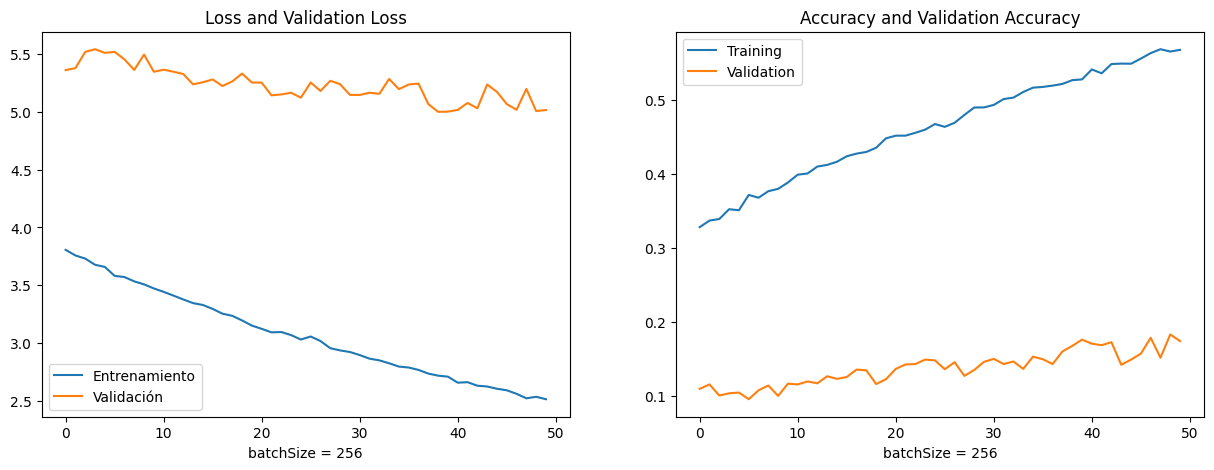

In [ ]:
history_df = pd.DataFrame(history.history)

print('\nbatchSize = '+str(batchSize))

plt.figure(figsize=(15,5))        #Width and Height of the graphs, respectively

plt.subplot(1,2,1)
#history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.legend()
plt.title('Loss and Validation Loss')
plt.xlabel('batchSize = '+str(batchSize))
print(("Minimum Validation Loss: {:0.4f} in epoch {:0.0f} ").format(history_df['val_loss'].min(), history_df['val_loss'].idxmin()))

plt.subplot(1,2,2)
#history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()
plt.plot(history.history['sparse_categorical_accuracy'], label='Training')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy and Validation Accuracy')
plt.xlabel('batchSize = '+str(batchSize))
print(("Maximum Validation Accuracy: {:0.4f} in epoch {:0.0f} ").format(history_df['val_sparse_categorical_accuracy'].max(), history_df['val_sparse_categorical_accuracy'].idxmax()))

print("\nEvaluation of the model with training data")
score = model.evaluate(X_train, y_train)
print("Test loss, Test accuracy:", score[0], score[1])

print("\nModel evaluation with validation data")
score = model.evaluate(X_val, y_val)
print("Test loss, Test accuracy:", score[0], score[1])

plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)       

In [ ]:
predict = model.predict(X_test, verbose=1)

29/29 [==============================] - 2s 63ms/step


In [ ]:
y_pred = []
confidence = []

for i in range(len(predict)):
    y_pred.append(np.argmax(predict[i]))
    confidence.append(predict[i][y_pred[i]].round(2))

y_pred = LE.inverse_transform(y_pred)

In [ ]:
print("\nEvaluation of the model on test data")
score = model.evaluate(X_test, y_test)
print("Test loss, Test accuracy:", score[0], score[1])


Evaluation of the model on test data
29/29 [==============================] - 2s 67ms/step - loss: 4.9701 - sparse_categorical_accuracy: 0.1811
Test loss, Test accuracy: 4.970127105712891 0.18111111223697662


In [ ]:
y_test = LE.inverse_transform(y_test)

In [ ]:
def img_read_resize(img_path):
    img = plt.imread(img_path)
    img_redim = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    return img_redim